# Transpilation best practices for QAOA workflows

This tutorial shows how applying domain-specific transpilation strategies allows to reduce circuit depth and 2-qubit gate count on qaoa circuits.

## Problem setting

We'll start our workflow with a graph that represents a hypothetical max-cut problem, for example:

In [1]:
from networkx import barabasi_albert_graph, draw
graph = barabasi_albert_graph(n=10, m=2, seed=42)

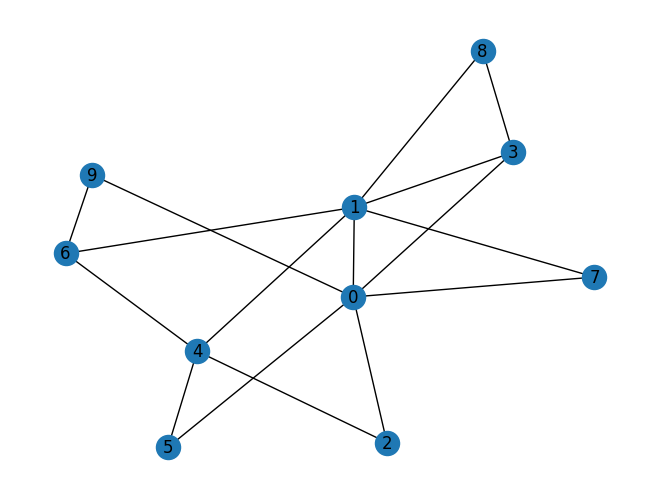

In [2]:
draw(graph, with_labels=True)

The graph above corresponds to the following operator.

In [3]:
from qopt_best_practices.utils import build_max_cut_paulis
from qiskit.quantum_info import SparsePauliOp

local_correlators = build_max_cut_paulis(graph)
cost_operator = SparsePauliOp.from_list(local_correlators)
print(cost_operator)

SparsePauliOp(['IIIIIIIIZZ', 'IIIIIIIZIZ', 'IIIIIIZIIZ', 'IIIIZIIIIZ', 'IIZIIIIIIZ', 'ZIIIIIIIIZ', 'IIIIIIZIZI', 'IIIIIZIIZI', 'IIIZIIIIZI', 'IIZIIIIIZI', 'IZIIIIIIZI', 'IIIIIZIZII', 'IZIIIIZIII', 'IIIIZZIIII', 'IIIZIZIIII', 'ZIIZIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


This operator maps to a 10 qubit QAOA circuit:

In [4]:
num_qubits = cost_operator.num_qubits
print(num_qubits)

10


And we'll fix the number of QAOA layers to 2 for both workflows:

In [5]:
qaoa_layers = 2

## Naive QAOA Workflow

Build QAOA circuit/ansatz:

In [6]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QAOAAnsatz
from qiskit.circuit import ParameterVector

# Initial state = equal superposition
initial_state = QuantumCircuit(num_qubits)
initial_state.h(range(num_qubits))

# Mixer operator = rx rotations
betas = ParameterVector("β", qaoa_layers)
mixer_operator = QuantumCircuit(num_qubits)
mixer_operator.rx(-2*betas[0], range(num_qubits))

# Use off-the-shelf qiskit QAOAAnsatz
qaoa_ansatz = QAOAAnsatz(
    cost_operator,
    initial_state = initial_state,
    mixer_operator = mixer_operator,
    reps = qaoa_layers,
)
qaoa_ansatz.measure_all()

Transpile circuit:

In [7]:
# Torino is too large for local simulation, 
# so instead, we generate an equivalent fake backend
# with cz gates and 19 qubits

# from qiskit_ibm_runtime.fake_provider import FakeTorino
# backend = FakeTorino()

from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler import CouplingMap

cmap = CouplingMap.from_heavy_hex(distance=3)
print(cmap.size())
backend = GenericBackendV2(num_qubits = 19, coupling_map = cmap, basis_gates = ["x", "sx", "cz", "id", "rz"], seed=0)

19


In [8]:
import time
from qiskit_ibm_runtime.fake_provider import FakeTorino
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

naive_pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
t0 = time.time()
naively_transpiled_qaoa = naive_pm.run(qaoa_ansatz)
print(f"transpilation time: {time.time() - t0} (s)")

transpilation time: 1.5895061492919922 (s)


In [9]:
naively_transpiled_qaoa.count_ops()

OrderedDict([('rz', 295),
             ('sx', 265),
             ('cz', 146),
             ('measure', 10),
             ('barrier', 1)])

In [10]:
naively_transpiled_qaoa.depth()

336

## Optimal QAOA Transpilation Workflow

The optimal QAOA workflow consists on the follwing steps:

1. We start off by only building the cost layer of the QAOA ansatz (this is the one that contains 2q gates)
2. We transpile the cost layer applying specific swap strategies as per [REF]
3. We then build the QAOA circuit by alternating layers of transpiled cost + mixer
4. We translate the circuit to the hardware native gates and route it to the optimal qubit layout through backend evaluation as per [REF]
   
Note: We manually keep track of the qubit permutations to recover the corresponding measurements (can probably be improved)

### 1. Build cost layer

In [11]:
# We are being lazy and taking advantage of the QAOAAnsatz class
# to build the cost layer

dummy_initial_state = QuantumCircuit(num_qubits)  # the real initial state is defined later
dummy_mixer_operator = QuantumCircuit(num_qubits)  # the real mixer is defined later

cost_layer = QAOAAnsatz(
    cost_operator,
    reps=1,
    initial_state=dummy_initial_state,
    mixer_operator=dummy_mixer_operator,
    name="QAOA cost block",
)
# we add measurements to keep track of the permutations
cost_layer.measure_all()

### 2. Transpile cost layer

In [12]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (
    BasisTranslator,
    UnrollCustomDefinitions,
    CommutativeCancellation
)

from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import (
    SwapStrategy,
    FindCommutingPauliEvolutions,
    Commuting2qGateRouter,
)
from qiskit.circuit.library.standard_gates.equivalence_library import _sel

# 1. choose swap strategy (in this case -> line)
swap_strategy = SwapStrategy.from_line([i for i in range(num_qubits)])
edge_coloring = {(idx, idx + 1): (idx + 1) % 2 for idx in range(num_qubits)}

# 2. define Pass manager for cost layer
pm_pre = PassManager(
    [        
        FindCommutingPauliEvolutions(),
        Commuting2qGateRouter(
            swap_strategy,
            edge_coloring,
        ),        
    ]
)

# 3. run pass manager for cost layer
swapped_cost_layer = pm_pre.run(cost_layer)

#### (Get measurement map)

In [13]:
from qopt_best_practices.swap_strategies import make_meas_map

# We build a "measurement map" that reflects the permutations, 
# only relevant for an odd number of qaoa layers.
# After that, we can remove the artificial measurements 
# that we introduced in the cost operator

if qaoa_layers % 2 == 1:
    meas_map = make_meas_map(swapped_cost_layer)
else:
    meas_map = {idx: idx for idx in range(num_qubits)}

swapped_cost_layer.remove_final_measurements()

### 3. Build QAOA Ansatz

In [14]:
# We now proceed to build the QAOA ansatz using the swapped cost layer

qaoa_circuit = QuantumCircuit(num_qubits, num_qubits)

# Add initial state -> equal superposition
qaoa_circuit.h(range(num_qubits))

# Re-parametrize the circuit
gammas = ParameterVector("γ", qaoa_layers)
betas = ParameterVector("β", qaoa_layers)

# Define mixer layer
mixer_layer = QuantumCircuit(num_qubits)
mixer_layer.rx(-2*betas[0], range(num_qubits))

# iterate over number of qaoa layers
# and alternate cost/reversed cost and mixer
for layer in range(qaoa_layers):

    bind_dict = {cost_layer.parameters[0]: gammas[layer]}
    bound_swapped_cost_layer = swapped_cost_layer.assign_parameters(bind_dict)
    
    bind_dict = {mixer_layer.parameters[0]: betas[layer]}
    bound_mixer_layer = mixer_layer.assign_parameters(bind_dict)

    if layer % 2 == 0:
        # even layer -> append cost
        qaoa_circuit.append(bound_swapped_cost_layer, range(num_qubits))
    else:
        # odd layer -> append reversed cost
        qaoa_circuit.append(bound_swapped_cost_layer.reverse_ops(), range(num_qubits))

    # the mixer layer is not reversed
    qaoa_circuit.append(bound_mixer_layer, range(num_qubits))

qaoa_circuit.barrier()

# iterate over measurement map to recover permutations
for qidx, cidx in meas_map.items():
    qaoa_circuit.measure(qidx, cidx)

# qaoa_circuit.draw("mpl")

### 4. Full circuit transpilation: Unroll gates and route to backend

In [15]:
from qopt_best_practices.qubit_selection import BackendEvaluator

# The backend evaluator finds the line of qubits with the best fidelity to map the circuit to
path_finder = BackendEvaluator(backend)
path, fidelity, num_subsets = path_finder.evaluate(num_qubits)

In [16]:
from qiskit.transpiler import Layout

# We use the obtained path to define the initial layout
initial_layout = Layout.from_intlist(path, qaoa_circuit.qregs[0])  # needs qaoa_circ

In [17]:
from qiskit.transpiler.passes import (
    FullAncillaAllocation,
    EnlargeWithAncilla,
    ApplyLayout,
    SetLayout
)

pm_post = PassManager(
    [        
        UnrollCustomDefinitions(_sel, basis_gates=backend.operation_names),
        BasisTranslator(_sel, target_basis=backend.operation_names),
        SetLayout(initial_layout),
        FullAncillaAllocation(backend.target),
        EnlargeWithAncilla(),
        ApplyLayout(),
        CommutativeCancellation(target=backend.target)
    ]
)
optimally_transpiled_qaoa = pm_post.run(qaoa_circuit)

## 2q Gate count comparison

In [18]:
naive_count = naively_transpiled_qaoa.count_ops().get("cz", 0)
optimal_count = optimally_transpiled_qaoa.count_ops().get("cz", 0)

print(f"2q gate count for naive circuit = {naive_count}")
print(f"2q gate count for optimal circuit = {optimal_count}")

2q gate count for naive circuit = 146
2q gate count for optimal circuit = 64


In [19]:
naive_depth = naively_transpiled_qaoa.depth(filter_function=lambda x: x.operation.name == "cz")
optimal_depth = optimally_transpiled_qaoa.depth(filter_function=lambda x: x.operation.name == "cz")

print(f"2q depth for naive circuit = {naive_depth}")
print(f"2q depth for optimal circuit = {optimal_depth}")

2q depth for naive circuit = 94
2q depth for optimal circuit = 34


## Sampler in simulation

Let's check that the distributions obtained from both circuits are equivalent:

In [20]:
naively_transpiled_qaoa.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

In [21]:
optimally_transpiled_qaoa.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

In [22]:
param_values = [0.1, 0.2, 0.3, 0.4]

In [23]:
from qiskit.primitives import Sampler

sampler = Sampler()

In [24]:
result_naive = sampler.run(naively_transpiled_qaoa, param_values).result()

In [25]:
result_optimal= sampler.run(optimally_transpiled_qaoa, param_values).result()

In [26]:
# print(result_optimal[0].data.c.get_counts())

In [27]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def plot_distribution(final_distribution):
    matplotlib.rcParams.update({"font.size": 10})
    final_bits = final_distribution.binary_probabilities()
    values = np.abs(list(final_bits.values()))
    top_4_values = sorted(values, reverse=True)[:4]
    positions = []
    for value in top_4_values:
        positions.append(np.where(values == value)[0])
    fig = plt.figure(figsize=(11, 6))
    ax = fig.add_subplot(1, 1, 1)
    plt.xticks(rotation=45)
    plt.title("Result Distribution")
    plt.xlabel("Bitstrings (reversed)")
    plt.ylabel("Probability")
    ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
    plt.show()

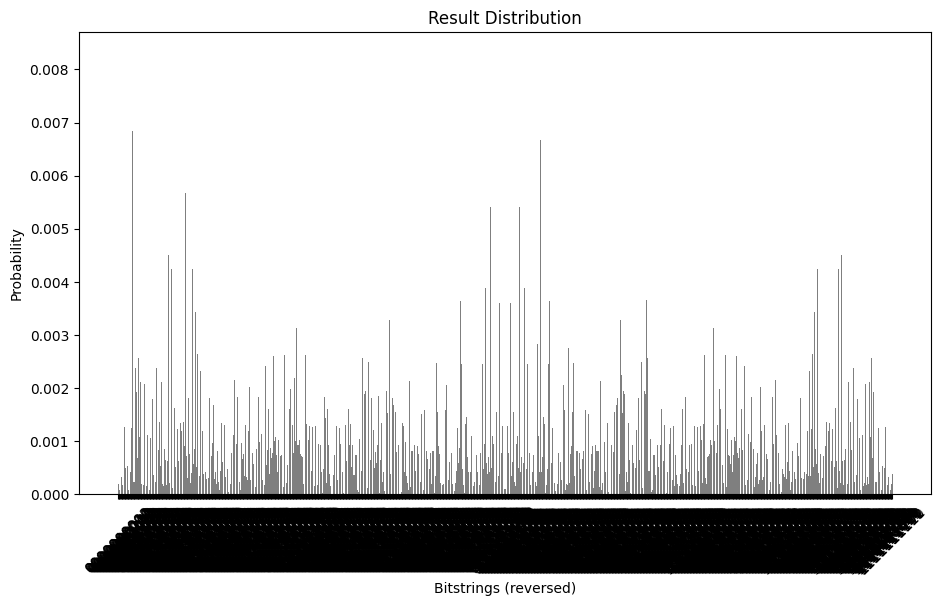

In [29]:
plot_distribution(result_naive.quasi_dists[0])

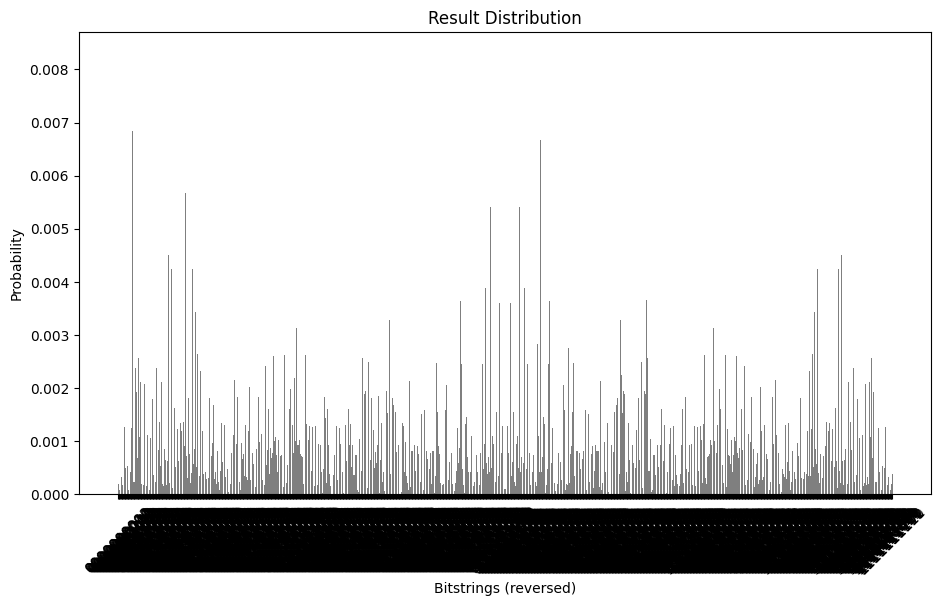

In [30]:
plot_distribution(result_optimal.quasi_dists[0])